# Wood moisture classification (wmc) model creation pipeline

The following code is adapted from the X-SENSING1 application of ST microelectronics

In [133]:
import numpy as np
import os
from tqdm import tqdm
import librosa
import librosa.display
import librosa.util
from IPython.display import Audio
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import keras.utils
from keras import layers
from keras import models
from keras import optimizers
import tensorflow as tf
from pickle import dump
import random

In [134]:
# Current version (for reproduction)
print("Keras:", keras.__version__)
print("TensorFlow:",tf.__version__)
print("librosa:", keras.__version__)

Keras: 2.4.3
TensorFlow: 2.4.1
librosa: 2.4.3


## Overview of the pipeline
    1. Import and convert audio data
    2. Prepare data
        2.1 Slice data into random frames
        2.2 Preprocess the data into LogMel spectrograms
        2.3 Normalize features
        2.4 One-hote encoding for labels
        2.5 Split data into training, validation and testing
        2.6 (Optional) Save the features

    3. Model
        3.1 Create and compile model
        3.2 Train the model
        3.3 Evaluate accuracy
        3.4 Save the model

The next steps have to be done with the STM32CubeIDE and the [X-Cube-AI](https://www.st.com/en/embedded-software/x-cube-ai.html) extension pack:

    4. Create a new project for the SensorTile.box named "wmc"
    5. Load the keras model and transform it to a 8 bit integer version
    6. Generate the code
    7. Copy wmc_data.c and wmc_data.h and replace the corresponding files in the STM32 application
    8. In wmc_featurescaler.c replace the arrays for the normalization from the ones saved in model/normalization/

## Global settings
__Important:__ These settings have to match the ones in the STM32 application.

In [135]:
# Sampling
sampling_freq = 48000 # kHz 
n_stft_columns = 32 # How many columns for the short time fourier transformation
frame_size = 512*n_stft_columns + 512 # For one spectrogram column 1024 samples are needed
n_frames = 100 # How many frames were recorded

# Realtime audio preprocessing
n_mels = 30 # Resolution (bins) of one stft column
n_fft = 1024 # Size for one fft
hop_length = 512 # Jumps between fft windows
fmin = 4000 # Lowest bin for the columns
top_db = 80

## 1. Import and convert the data
Load the files from the data directory. The labels for the files are specified in model/dataset/labels.txt.

In [136]:
dataset_dir = './dataset'
fileset_path = path = os.path.join(dataset_dir, 'labels.txt')
fileset = np.loadtxt(fileset_path, dtype=str)

# 3 classes : 0 dry, 1 semiwet, 2 wet
class_names = ['dry', 'semiwet', 'wet']
labels = {
    'dry' : 0,
    'semiwet' : 1,
    'wet' : 2,
}


# x is a list of the recordings and y is a list of the respective labels (targets)
x = []
y = []

# Iteratate over all recordings defined in labels.txt
for file in tqdm(fileset):
    file_path, file_label = file
    file_path = os.path.join(dataset_dir, file_path)
    
    signal, _ = librosa.load(file_path, sr=sampling_freq, mono=True, dtype=np.float32)   
    # Cut off total samples because recording takes a bit more samples
    signal = signal[0:n_frames*frame_size]
    
    label = labels[file_label]
    
    x.append(signal)
    y.append(label)

100%|██████████| 18/18 [00:00<00:00, 142.33it/s]


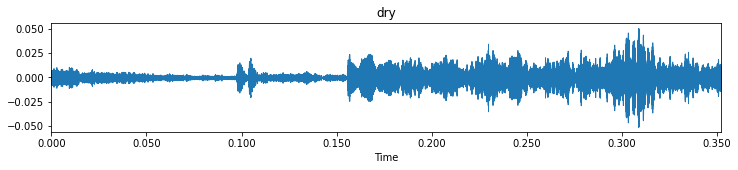

In [137]:
# Check a random sample of first recording
rand = random.randint(0, n_frames)
recording1 = x[1]
frame = recording1[frame_size*rand:frame_size*(rand+1)]

plt.figure(figsize=(12, 2))
plt.title(class_names[y[1]])
librosa.display.waveplot(frame, sr=sampling_freq)
Audio(frame, rate=sampling_freq)

## 2. Prepare the data

### 2.1 Slice data into random frames
Each audio recording contains the specified number of frames (n_frames). To generalize the model a number of random positioned frames will be selected from the recording.

__Important:__ The number of random frames is larger than the actual number of frames recorded!

Each frame rhen will contain 16,896 samples (32 * 512 + 512) to create a 32 column spectrogram with n_fft=1024 and hop_length=512

In [139]:
# Each frame will now be an entry in the list
x_framed = []
y_framed = []

# Number of randomly selected frames
n_frames_sel = 1000

# Fixed random seed
random.seed(10)

# Iteratate over all recordings and create random frames
for i in range(len(x)):
    x_tmp = np.asarray(x[i])
    for k in range(n_frames_sel):
        rand = random.randint(0, (n_frames-1)*frame_size)
        frame = x_tmp[rand:rand + frame_size]
        x_framed.append(np.transpose(frame))
    y_framed.append(np.full(n_frames_sel, y[i]))
    
# Convert into numpy arrays
x_framed = np.asarray(x_framed)
y_framed = np.asarray(y_framed)

# Reshape labels 
y_framed = y_framed.reshape(y_framed.shape[0]*y_framed.shape[1], )

print("x_framed shape: ", x_framed.shape) # Each frame of 16,896 samples can be used to create a spectrogram 
print("y_framed shape: ", y_framed.shape) # Corresponding label for each frame


x_framed shape:  (18000, 16896)
y_framed shape:  (18000,)


### 2.2 Preprocess the data into LogMel spectrograms
Frames are transformed into the spectrograms of size n_mels*n_stft_columns

In [140]:
# Spectograms of frames which will be the feautures for the neural network
x_features = []
y_features = y_framed

for frame in tqdm(x_framed):
    # Create a mel-scaled spectrogram
    S_mel = librosa.feature.melspectrogram(y=frame, sr=sampling_freq, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, center=False, fmin=fmin)
    # Scale according to reference power
    S_mel = S_mel / S_mel.max()
    # Convert to dB
    S_log_mel = librosa.power_to_db(S_mel, top_db=top_db)
    x_features.append(S_log_mel)

# Convert into numpy array
x_features = np.asarray(x_features)


# Stats of the features
n_features = n_frames_sel*len(x)

print('There are ' + str(n_features) + ' features in the set and each feature represented ' + str(n_mels) + 'x' + str(n_stft_columns) + ' spectograms.')
print('')
print('The shape of the feature numpy array is: ' + str(x_features.shape))

100%|██████████| 18000/18000 [00:33<00:00, 544.36it/s]


There are 18000 features in the set and each feature represented 30x32 spectograms.

The shape of the feature numpy array is: (18000, 30, 32)


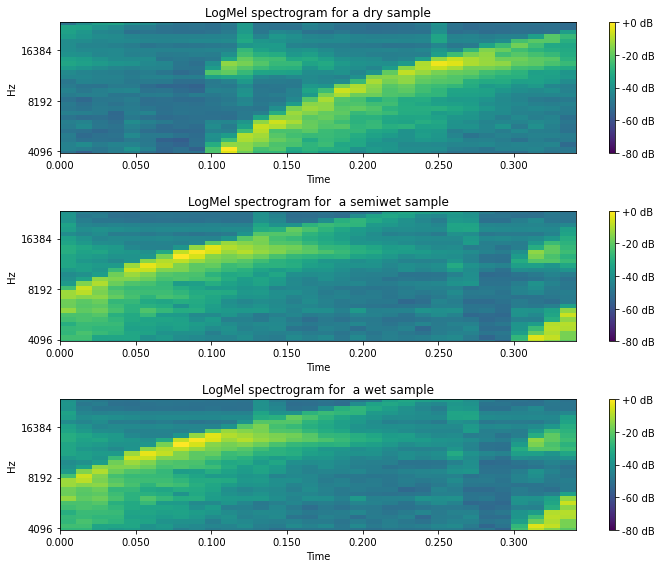

In [141]:
# Plot the first random positioned spectrogram generated for each feature class
plt.figure(figsize=(10, 8))
plt.subplot(311)


first_index = np.argmax(y_framed == 0)
librosa.display.specshow(x_features[first_index], sr=sampling_freq, y_axis='mel', fmin=fmin, fmax=sampling_freq/2,
                         x_axis='time', cmap='viridis', vmin=-top_db)
plt.colorbar(format='%+2.0f dB')
plt.title('LogMel spectrogram for a ' + class_names[y_features[first_index]] + ' sample')


plt.subplot(312)
second_index = np.argmax(y_framed == 1)
librosa.display.specshow(x_features[second_index], sr=sampling_freq, y_axis='mel', fmin=fmin, fmax=sampling_freq/2,
                         x_axis='time', cmap='viridis', vmin=-top_db)
plt.colorbar(format='%+2.0f dB')
plt.title('LogMel spectrogram for  a ' + class_names[y_features[second_index]] + ' sample')


plt.subplot(313)
third_index = np.argmax(y_framed == 2)
librosa.display.specshow(x_features[second_index], sr=sampling_freq, y_axis='mel', fmin=fmin, fmax=sampling_freq/2,
                         x_axis='time', cmap='viridis', vmin=-top_db)
plt.colorbar(format='%+2.0f dB')
plt.title('LogMel spectrogram for  a ' + class_names[y_features[third_index]] + ' sample')


plt.tight_layout()
plt.show()

# Save figures if needed
#plt.savefig('spectograms.jpg', dpi = 300, bbox_inches='tight')

### 2.3 Normalize features
Normalize features by removing the mean and scaling to unit variance. Save the feature scalers to model/normalize.

In [142]:
# Flatten features for scaling
x_features_r = np.reshape(x_features, (len(x_features), n_mels * n_stft_columns))

# Create a feature scaler
scaler = preprocessing.StandardScaler().fit(x_features_r)
mean = scaler.mean_
std = scaler.scale_

#  Save feature scaler
normalize_dir = './normalize/'
np.savetxt(normalize_dir + 'mean.csv', mean.reshape(240, 4),  fmt='%.10e', delimiter=",", newline=",\n")
np.savetxt( normalize_dir + 'std.csv', std.reshape(240, 4),  fmt='%.10e', delimiter=",", newline=",\n")
dump(scaler, open(normalize_dir + 'scaler.pkl', 'wb'))

# Apply the feature scaler 
x_features_s = scaler.transform(x_features_r)

### 2.4 One hot encoding of labels
Keras requires one hot encoded labels.

In [143]:
# Convert labels to categorical one-hot encoding
y_features_hot = tf.keras.utils.to_categorical(y_features, num_classes=len(class_names))

print('The shape of the one-hot encoded labels np array is: ' , y_features_hot.shape)

The shape of the one-hot encoded labels np array is:  (18000, 3)


### 2.5 Split data into training, validation and test
Use 25% for testing. The remaining 75% of the features are split in 25% for validation and 75% for training.

In [147]:
x_train, x_test, y_train, y_test = train_test_split(x_features_s,
                                                    y_features_hot,
                                                    test_size=0.25,
                                                    random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.25,
                                                  random_state=1)

print('Training samples:', x_train.shape)
print('Validation samples:', x_val.shape)
print('Test samples:', x_test.shape)

Training samples: (10125, 960)
Validation samples: (3375, 960)
Test samples: (4500, 960)


### 2.6 (Optional) Save the features
Save the features to a csv file in a format X-CUBE-AI can understand, that is, for each tensor, the values are in a flattened vector.

In [148]:
#val_dir = './validation/'
#np.savetxt(val_dir + 'x_train.csv', x_train.reshape(len(x_train), n_mels*n_stft_columns), delimiter=",")
#np.savetxt(val_dir + 'y_train.csv', y_train, delimiter=",")
#np.savetxt(val_dir + 'x_val.csv', x_val.reshape(len(x_val), n_mels*n_stft_columns), delimiter=",")
#np.savetxt(val_dir + 'y_val.csv', y_val, delimiter=",")
#np.savetxt(val_dir + 'x_test.csv', x_test.reshape(len(x_test), n_mels*n_stft_columns), delimiter=",")
#np.savetxt(val_dir + 'y_test.csv', y_test, delimiter=",")

## 3 Model

### 3.1 Create and compile model
Build a sequential convolutional network classifier model

In [149]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(30, 32, 1), data_format='channels_last'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(9, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

# Print model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 30, 16)        160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 15, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 13, 16)        2320      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 5193      
_________________________________________________________________
dense_9 (Dense)              (None, 3)                

In [150]:
# Compile model with choosing a loss and an omptimizer
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy',  metrics=['acc'])

###  3.2 Train the model

In [151]:
# Reshape features to include channel
x_train_r = x_train.reshape(x_train.shape[0], 30, 32, 1)
x_val_r = x_val.reshape(x_val.shape[0], 30, 32, 1)
x_test_r = x_test.reshape(x_test.shape[0], 30, 32, 1)

In [152]:
# Train the model
history = model.fit(x_train_r, y_train, validation_data=(x_val_r, y_val),
                    batch_size=500, epochs=20, verbose=2)

Epoch 1/20
21/21 - 3s - loss: 0.8082 - acc: 0.5575 - val_loss: 0.6544 - val_acc: 0.5813
Epoch 2/20
21/21 - 2s - loss: 0.6221 - acc: 0.6360 - val_loss: 0.6191 - val_acc: 0.6444
Epoch 3/20
21/21 - 2s - loss: 0.5885 - acc: 0.6576 - val_loss: 0.6097 - val_acc: 0.6210
Epoch 4/20
21/21 - 2s - loss: 0.5658 - acc: 0.6646 - val_loss: 0.5607 - val_acc: 0.6841
Epoch 5/20
21/21 - 2s - loss: 0.4958 - acc: 0.7021 - val_loss: 0.4627 - val_acc: 0.7132
Epoch 6/20
21/21 - 2s - loss: 0.4455 - acc: 0.7395 - val_loss: 0.4396 - val_acc: 0.7751
Epoch 7/20
21/21 - 2s - loss: 0.4074 - acc: 0.8015 - val_loss: 0.3895 - val_acc: 0.7772
Epoch 8/20
21/21 - 2s - loss: 0.3233 - acc: 0.8846 - val_loss: 0.2759 - val_acc: 0.9437
Epoch 9/20
21/21 - 2s - loss: 0.2248 - acc: 0.9419 - val_loss: 0.1744 - val_acc: 0.9570
Epoch 10/20
21/21 - 2s - loss: 0.1440 - acc: 0.9701 - val_loss: 0.1147 - val_acc: 0.9784
Epoch 11/20
21/21 - 2s - loss: 0.0944 - acc: 0.9854 - val_loss: 0.0759 - val_acc: 0.9905
Epoch 12/20
21/21 - 2s - loss:

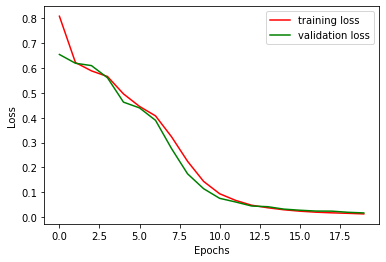

In [153]:
# Plot losses
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.clf()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss, color='r', label='training loss')
plt.plot(val_loss, color='g', label='validation loss')
plt.legend()

### 3.3 Evaluate Accuracy
Compare how the model performs on the test dataset:

In [154]:
print('Evaluate model:')
results = model.evaluate(x_test_r, y_test)
print(results)
print('Test loss: {:f}'.format(results[0]))
print('Test accuracy: {:.2f}%'.format(results[1] * 100))

Evaluate model:
141/141 [==============================] - 1s 6ms/step - loss: 0.0302 - acc: 0.9971
[0.030197445303201675, 0.9971110820770264]
Test loss: 0.030197
Test accuracy: 99.71%


Accuracy = 99.71%


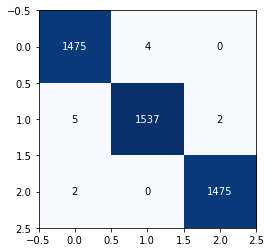

In [155]:
# Plot a confusion matrix
y_pred = model.predict(x_test_r)

y_pred_class_n = np.argmax(y_pred, axis=1)
y_true_class_n = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_class_n, y_pred_class_n)
np.set_printoptions(precision=2)
print("Accuracy = {:.2f}%".format(accuracy * 100))

cm = confusion_matrix(y_true_class_n, y_pred_class_n, labels=[0,1,2])

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.imshow(cm, cmap=plt.cm.Blues)

### 3.4 Save the model
When saving the model in a `.h5` file format, the X-CUBE-AI tool can import the pre-trained model and generate an equivalent C model optmized for STM32 devices.

In [156]:
# Save the model into an HDF5 file ‘model.h5’
model.save('wmc.h5')